Idea is to use a rotated bounding box to better capture the building using the script `process_data_classification_rotated_bounding_box.py`

In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
class CombinedLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
#         bce_dice = BCEDiceLoss()
#         lovaz_loss = LovaszLossBinary()
#         dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss

In [14]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classification_labels = pd.read_csv(data_dir/"train_pre_post_rotated_bbox.csv")
image_crops_dir_post = data_dir / "classification_crops_post_rotated_bbox"
image_crops_dir_pre = data_dir / "classification_crops_pre_rotated_bbox"

damage_crops_test_folder = data_dir / "classification_crops_rotated_bbox_test"

In [4]:
classification_labels.head()

,uuid,img_id_pre,img_id_post,label,crop_filename
0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8.png
1,437988fc-fb7e-4b0e-8ccf-403015a737b3,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,437988fc-fb7e-4b0e-8ccf-403015a737b3.png
2,63d78637-7c40-40c7-a1b3-55152a64415a,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,63d78637-7c40-40c7-a1b3-55152a64415a.png
3,31ccdff0-b7f7-4884-8e55-d35e4d2c1770,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,31ccdff0-b7f7-4884-8e55-d35e4d2c1770.png
4,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b.png


In [5]:
def get_train_valid_ids(classification_labels_df, valid_pct=0.1, img_id_col="img_id_post", random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df[img_id_col].unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df[img_id_col].isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df[img_id_col].isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids
    

In [6]:
train_ids, valid_ids = get_train_valid_ids(classification_labels)

In [7]:
# classification_labels_resampled= pd.concat([
#     classification_labels[(classification_labels.label!= 0) & (~classification_labels.crop_filename.isin(valid_ids))],
#     classification_labels[(classification_labels.label==0) & (~classification_labels.crop_filename.isin(valid_ids))].sample(frac=0.2),
#     classification_labels[classification_labels.crop_filename.isin(valid_ids)],
# ])
# classification_labels_resampled.label.value_counts(normalize=True), classification_labels_resampled[(~classification_labels.crop_filename.isin(valid_ids))].label.value_counts(normalize=True), 

In [8]:

def is_valid_func(img_fname):
    id = Path(img_fname).name
    return id in valid_ids


In [9]:

def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#


In [10]:
size=128
bs=32
partial_data_frac=0.2
src = (ImageList
       .from_df(classification_labels, path=image_crops_dir_post, cols=['crop_filename'])
#        .use_partial_data(partial_data_frac)
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
#         .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss();
learn.to_fp16();

In [11]:
classification_labels.label.unique()

array([0, 2, 1, 3])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


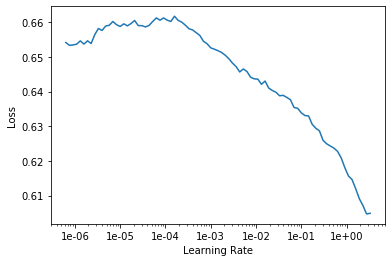

In [12]:
learn.lr_find()
learn.recorder.plot();

In [13]:
learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.491344,0.484127,0.793903,0.789676,03:23
1,0.485719,0.478583,0.804392,0.785747,03:25
2,0.483963,0.476318,0.808624,0.803903,03:23


In [14]:
learn.save('22Dec-rotated-bbox-damage-classification')

In [20]:
learn.load('22Dec-rotated-bbox-damage-classification');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


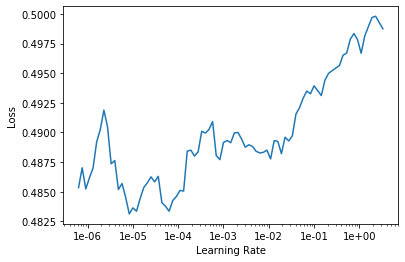

In [21]:
size=128
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn.to_fp32()
learn.data = data
learn.to_fp16()
learn.lr_find()
learn.recorder.plot();

In [22]:


learn.fit_one_cycle(3, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.486130,0.475966,0.809115,0.805172,03:23
1,0.484535,0.475761,0.810280,0.805325,03:24
2,0.483575,0.475448,0.810219,0.804628,03:24


In [23]:
learn.save('22Dec-rotated-bbox-damage-classification')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


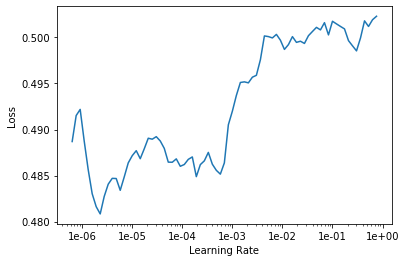

In [24]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot();

In [25]:
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='22Dec-rotated-bbox-damage-classification_unfrozen'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]


learn.fit_one_cycle(6, max_lr=1e-6, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.483555,0.474995,0.811078,0.803569,04:47
1,0.478454,0.474638,0.812550,0.803661,05:00
2,0.477781,0.474861,0.811936,0.806214,04:59
3,0.478280,0.474415,0.812366,0.805690,04:52
4,0.479390,0.473904,0.814083,0.803436,04:54
5,0.476102,0.474155,0.813347,0.806103,04:51


Better model found at epoch 0 with f1 value: 0.8035688996315002.
Better model found at epoch 1 with f1 value: 0.8036611080169678.
Better model found at epoch 2 with f1 value: 0.8062142729759216.


In [27]:
del learn
gc.collect()


learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=0.5, gamma=3);
learn.to_fp16();
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='22Dec-rotated-bbox-damage-classification_alpha05_gamma3'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1, monitor='f1')
          ]


learn.fit_one_cycle(6, max_lr=1e-4, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.204766,0.185956,0.771024,0.747312,03:21
1,0.189451,0.181884,0.792554,0.784924,03:21
2,0.185333,0.178907,0.798197,0.792064,03:22
3,0.185187,0.177954,0.803778,0.798107,03:23
4,0.183084,0.176836,0.807152,0.803640,03:22
5,0.184098,0.176271,0.809912,0.802620,03:22


Better model found at epoch 0 with f1 value: 0.747312068939209.
Better model found at epoch 1 with f1 value: 0.7849237322807312.
Better model found at epoch 2 with f1 value: 0.7920640110969543.
Better model found at epoch 3 with f1 value: 0.7981066107749939.
Better model found at epoch 4 with f1 value: 0.8036397099494934.


In [28]:
# hmm, this is no good
del learn
gc.collect()


learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=0.75, gamma=3);
learn.to_fp16();
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='22Dec-rotated-bbox-damage-classification_alpha075_gamma3'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1, monitor='f1')
          ]


learn.fit_one_cycle(6, max_lr=1e-4, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.117271,0.105037,0.769368,0.743907,03:24
1,0.107941,0.101743,0.793044,0.780026,03:29
2,0.103287,0.100122,0.800159,0.775811,03:28
3,0.103072,0.098539,0.806171,0.767417,03:26
4,0.102340,0.097959,0.809790,0.762834,03:30
5,0.102570,0.097842,0.811016,0.760430,03:26


Better model found at epoch 0 with f1 value: 0.7439070343971252.
Better model found at epoch 1 with f1 value: 0.780026376247406.


In [30]:
del learn
gc.collect()

best_alpha = 0.25
best_gamma=2.
best_model = '22Dec-rotated-bbox-damage-classification_unfrozen'
learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss(alpha=best_alpha, gamma=best_gamma);
learn.to_fp16();
learn.load(best_model)
predictions, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y = torch.argmax(predictions, dim=1)

In [31]:
labels = pd.read_csv(data_dir/"test_polygons.csv")
labels["crop_filename"] = labels.polygon_id.apply(lambda x: f"{x}.png")

polygon_ids = [x.name.replace('.png', '') for x in data.test_dl.dataset.items]
prediction_cls = [x+1 for x in y.numpy()]

test_results = pd.DataFrame(data={'polygon_id': polygon_ids, 'damage_cls': prediction_cls})
test_results = labels.merge(test_results, left_on='polygon_id', right_on='polygon_id')
test_results.geometry = test_results.geometry.apply(lambda x: wkt.loads(x).exterior)
test_results.img_id = test_results.img_id.str.replace('localization', 'damage')

test_results.head()

,geometry,value,polygon_id,img_id,crop_filename,damage_cls
0,"LINEARRING (622 0, 622 2, 624 2, 624 4, 626 4,...",255.0,81af5119-6405-4945-b878-39959bf5fe59,test_damage_00000_prediction.png,81af5119-6405-4945-b878-39959bf5fe59.png,1
1,"LINEARRING (744 0, 744 4, 746 4, 746 8, 748 8,...",255.0,874f04d5-31a0-4d02-a806-63284e22f816,test_damage_00000_prediction.png,874f04d5-31a0-4d02-a806-63284e22f816.png,1
2,"LINEARRING (576 42, 576 44, 572 44, 572 46, 57...",255.0,492a78ad-86f9-4099-86f9-3eeee4e8c3e5,test_damage_00000_prediction.png,492a78ad-86f9-4099-86f9-3eeee4e8c3e5.png,1
3,"LINEARRING (394 78, 394 80, 388 80, 388 82, 38...",255.0,f87c9445-b7fa-40b8-bfdf-ab1368d3f894,test_damage_00000_prediction.png,f87c9445-b7fa-40b8-bfdf-ab1368d3f894.png,1
4,"LINEARRING (684 108, 686 108, 686 106, 688 106...",255.0,e23cf0eb-953a-461a-ab3d-73e0b2cbd6bd,test_damage_00000_prediction.png,e23cf0eb-953a-461a-ab3d-73e0b2cbd6bd.png,1


In [33]:
test_results.damage_cls.value_counts(normalize=True)

1    0.88484
4    0.06650
2    0.04554
3    0.00312
Name: damage_cls, dtype: float64

In [34]:
from cv2 import fillPoly, imwrite


def create_image(img_id, output_path):
    mask_img = np.zeros((1024, 1024, 1), np.uint8)
    img_polys = test_results[test_results.img_id == img_id]
    if len(img_polys) > 0:
        for r in img_polys.iterrows():
            row = r[1]
            poly_np = np.array(row.geometry.coords, np.int32)
            fillPoly(mask_img, [poly_np], row['damage_cls'])

    imwrite(str(output_path / img_id), mask_img)
    return mask_img

In [35]:

output_path = data_dir/"test_masks"

img_ids = [re.findall(r'\d+', x.name )[0] for x in (data_dir/"test"/"images").ls() if 'post' in x.name]
img_ids = [f"test_damage_{x}_prediction.png" for x in img_ids]

outputs = [create_image(img_id, output_path) for img_id in tqdm(img_ids)]

100%|██████████| 933/933 [00:07<00:00, 128.73it/s]


In [36]:
from submission_utils import load_and_validate_image
_=[load_and_validate_image(x) for x in output_path.ls()]